In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
def covid_data():
    covid = pd.read_csv('Covid Data.csv')
    
    covid.columns = [x.lower() for x in covid.columns] # Lowercase all column names
    
    covid = covid.rename(columns={'inmsupr':'immuno','hipertension':'hypertension',
                                  'clasiffication_final':'classification','renal_chronic':'renal'})
    
    return covid

covid = covid_data()
covid.head()

,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,...,asthma,immuno,hypertension,other_disease,cardiovascular,obesity,renal,tobacco,classification,icu
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [3]:
# Check for NaN
covid.isna().sum()

usmer             0
medical_unit      0
sex               0
patient_type      0
date_died         0
intubed           0
pneumonia         0
age               0
pregnant          0
diabetes          0
copd              0
asthma            0
immuno            0
hypertension      0
other_disease     0
cardiovascular    0
obesity           0
renal             0
tobacco           0
classification    0
icu               0
dtype: int64

In [4]:
# Map all date of death '9999-99-99' into new column as 0 to specify that case has not died
covid['died'] = covid.date_died.map({'9999-99-99':0}) 

# Recode NaN from map with 1 to specify that case has died
covid['died'] = covid.died.fillna(1)

# Confirm
covid.died.value_counts()
# covid.loc[covid['date_died'] == '9999-99-99', ['date_died']].count() # confirm original

0.0    971633
1.0     76942
Name: died, dtype: int64

In [5]:
covid.shape

(1048575, 22)

In [6]:
covid.patient_type.value_counts() # 1=returned home, 2=hospitalized

1    848544
2    200031
Name: patient_type, dtype: int64

In [7]:
# Drop these two columns before recoding
covid2 = covid.drop(['age','date_died'], axis=1)

# Convert all columns to int
covid2 = covid2.astype(int)

# Recode as np.nan (missing) for all columns
covid2 = covid2.replace([97,98,99], np.nan)

# Recode all columns: 2 to 0
covid2 = covid2.replace(2, 0)

In [8]:
covid2.patient_type.value_counts() # 1=returned home, 0=hospitalized

1    848544
0    200031
Name: patient_type, dtype: int64

In [9]:
covid2['patient_type'] = covid2.patient_type.map({0:1, 1:0}) # 0=returned home, 1=hospitalized
covid2.patient_type.value_counts()

0    848544
1    200031
Name: patient_type, dtype: int64

In [10]:
# Combine 'age' back into main dataframe
covid_clean = pd.concat([covid.age, covid2], axis=1)
covid_clean.head()

,age,usmer,medical_unit,sex,patient_type,intubed,pneumonia,pregnant,diabetes,copd,...,immuno,hypertension,other_disease,cardiovascular,obesity,renal,tobacco,classification,icu,died
0,65,0,1,1,0,NaN,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,NaN,1
1,72,0,1,0,0,NaN,1.0,NaN,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,5,NaN,1
2,55,0,1,0,1,1.0,0.0,NaN,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,1
3,53,0,1,1,0,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,NaN,1
4,68,0,1,0,0,NaN,0.0,NaN,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,NaN,1


In [11]:
covid_clean.isna().sum()

age                    0
usmer                  0
medical_unit           0
sex                    0
patient_type           0
intubed           855869
pneumonia          16003
pregnant          527265
diabetes            3338
copd                3003
asthma              2979
immuno              3404
hypertension        3104
other_disease       5045
cardiovascular      3076
obesity             3032
renal               3006
tobacco             3220
classification         0
icu               856032
died                   0
dtype: int64

In [12]:
# Drop these features
covid_clean = covid_clean.drop(['usmer','medical_unit','intubed','pregnant',
                                'other_disease','classification','icu'], axis=1)
covid_clean.head()

,age,sex,patient_type,pneumonia,diabetes,copd,asthma,immuno,hypertension,cardiovascular,obesity,renal,tobacco,died
0,65,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
1,72,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1
2,55,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,53,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,68,0,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [13]:
covid_clean.isna().sum()

age                   0
sex                   0
patient_type          0
pneumonia         16003
diabetes           3338
copd               3003
asthma             2979
immuno             3404
hypertension       3104
cardiovascular     3076
obesity            3032
renal              3006
tobacco            3220
died                  0
dtype: int64

In [14]:
# Drop rows with NaN
covid_clean = covid_clean.dropna(how='any')

# Convert all columns to int
covid_clean = covid_clean.astype(int)

# See shape
covid_clean.shape

(1026832, 14)

In [15]:
# Check to see that all columns (except 'age') are coded as 0 and 1
for x in covid_clean.columns[1:]:
    print(covid_clean[x].value_counts(dropna=False))

1    513984
0    512848
Name: sex, dtype: int64
0    834166
1    192666
Name: patient_type, dtype: int64
0    888573
1    138259
Name: pneumonia, dtype: int64
0    904041
1    122791
Name: diabetes, dtype: int64
0    1012398
1      14434
Name: copd, dtype: int64
0    996284
1     30548
Name: asthma, dtype: int64
0    1013166
1      13666
Name: immuno, dtype: int64
0    866839
1    159993
Name: hypertension, dtype: int64
0    1006618
1      20214
Name: cardiovascular, dtype: int64
0    869519
1    157313
Name: obesity, dtype: int64
0    1008423
1      18409
Name: renal, dtype: int64
0    943940
1     82892
Name: tobacco, dtype: int64
0    951850
1     74982
Name: died, dtype: int64


In [16]:
# Rearrange columns
covid_clean = covid_clean[['age','sex','pneumonia','diabetes','copd','asthma','immuno','hypertension',
                           'cardiovascular','obesity','renal','tobacco','patient_type','died']]

# Rename columns
covid_clean = covid_clean.rename(columns={'age':'Age','sex':'Sex','pneumonia':'Pneumonia','diabetes':'Diabetes',
                                          'copd':'COPD','asthma':'Asthma','immuno':'Immunosuppressed',
                                          'hypertension':'Hypertension','cardiovascular':'Cardiovascular',
                                          'obesity':'Obese','renal':'Chronic renal','tobacco':'Smoke',
                                          'patient_type':'Hospitalized','died':'Died'})

covid_clean.head()

,Age,Sex,Pneumonia,Diabetes,COPD,Asthma,Immunosuppressed,Hypertension,Cardiovascular,Obese,Chronic renal,Smoke,Hospitalized,Died
0,65,1,1,0,0,0,0,1,0,0,0,0,0,1
1,72,0,1,0,0,0,0,1,0,1,1,0,0,1
2,55,0,0,1,0,0,0,0,0,0,0,0,1,1
3,53,1,0,0,0,0,0,0,0,0,0,0,0,1
4,68,0,0,1,0,0,0,1,0,0,0,0,0,1


In [17]:
covid_clean.to_csv('final_covid.csv', index=False)

# Data visualization

In [17]:
X = covid_clean.drop('Died', axis=1)
y = covid_clean['Died']

In [18]:
for x in covid_clean.columns[1:-1]:
    print(pd.crosstab(covid_clean.Died, covid_clean[x], margins=True))
    print()

Sex        0       1      All
Died                         
0     464577  487273   951850
1      48271   26711    74982
All   512848  513984  1026832

Pneumonia       0       1      All
Died                              
0          866613   85237   951850
1           21960   53022    74982
All        888573  138259  1026832

Diabetes       0       1      All
Died                             
0         856852   94998   951850
1          47189   27793    74982
All       904041  122791  1026832

COPD        0      1      All
Died                         
0      941300  10550   951850
1       71098   3884    74982
All   1012398  14434  1026832

Asthma       0      1      All
Died                          
0       922749  29101   951850
1        73535   1447    74982
All     996284  30548  1026832

Immunosuppressed        0      1      All
Died                                     
0                  940692  11158   951850
1                   72474   2508    74982
All               1013166  

In [19]:
# Create a dataframe of features sorted by the most 'yes' response for visualization.
feature = []
number = []

for col in covid_clean.columns[2:]: # Exclude Age and Sex
    count = covid_clean[col].sum()
    feature.append(col)
    number.append(count)
    
df_count = pd.concat([pd.DataFrame(feature, columns=['feature']), 
                      pd.DataFrame(number, columns=['number'])], axis=1).sort_values('number', ascending=True)
df_count

,feature,number
4,Immunosuppressed,13666
2,COPD,14434
8,Chronic renal,18409
6,Cardiovascular,20214
3,Asthma,30548
11,Died,74982
9,Smoke,82892
1,Diabetes,122791
0,Pneumonia,138259
7,Obese,157313


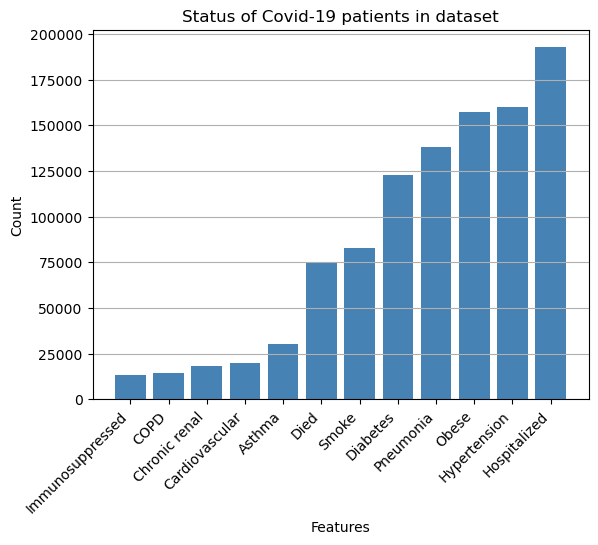

In [20]:
# Create a barplot of features, excluding Age and Sex

def create_barplot(sort_TF):
    figure, ax = plt.subplots(1, 1)

    n = 1
    for col in df_count.sort_values('number', ascending=sort_TF).feature.values:
        ax.bar(data=covid_clean, x=n, height=covid_clean[col].sum(), color='steelblue')
        n += 1

    ax.set_xticks(list(range(1,13))) # Tick number
    label_names = list(df_count.sort_values('number', ascending=sort_TF).feature.values) # Tick label
    ax.set_xticklabels(labels=label_names, rotation=45, ha='right') # Change labels according to sort

    plt.xlabel('Features')
    plt.ylabel('Count')
    plt.title('Status of Covid-19 patients in dataset')
    plt.grid(axis='y')
    plt.show()
    
create_barplot(True) # True = ascending

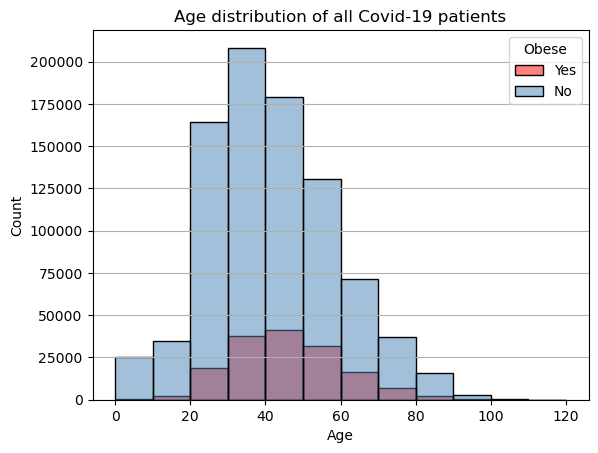

In [21]:
# Create a histogram of selected feature by age distribution

def create_agedist(feature_name):
    if feature_name == 'Sex': # Create unique legend name for Sex
        legend_name = ['Male','Female']
    else:
        legend_name = ['Yes','No']

    age_hist = sns.histplot(data=covid_clean, x='Age', bins=12, binrange=[0,120], 
                            hue=feature_name, palette=['steelblue','red'])

    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title('Age distribution of all Covid-19 patients')
    plt.legend(legend_name, title=feature_name, loc=1)
    plt.grid(axis='y')
    plt.show()

create_agedist('Obese') # Enter name of feature

# Creating a model

In [22]:
covid_clean.Died.value_counts()

0    951850
1     74982
Name: Died, dtype: int64

In [23]:
holdout_id = covid_clean.sample(frac=0.2, random_state=1).index # Create a holdout set for final evaluation

df_holdout = covid_clean[covid_clean.index.isin(holdout_id)]
df_train = covid_clean[~covid_clean.index.isin(holdout_id)]
print(df_holdout.shape)
print(df_train.shape)

(205366, 14)
(821466, 14)


In [24]:
df_train.Died.value_counts()

0    761537
1     59929
Name: Died, dtype: int64

In [25]:
X = df_train.drop('Died', axis=1)
y = df_train.Died

In [27]:
# Resample to get a more balanced number
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=1)
X_res, y_res = rus.fit_resample(X, y)

y_res.value_counts()

# ros = RandomOverSampler(sampling_strategy=0.5, random_state=1)
# X_res, y_res = ros.fit_resample(X, y)

# y_res.value_counts()

0    119858
1     59929
Name: Died, dtype: int64

### Logistic regression

In [78]:
%%time

clf = LogisticRegression(random_state=1, max_iter=1000)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

params = {'penalty':['l1','l2'],
          'C':[0.1,1,10],
          'solver':['lbfgs','liblinear']}

grid_log = GridSearchCV(clf, params, cv=skf).fit(X_res, y_res)

Wall time: 44.1 s


In [79]:
print(grid_log.best_score_)
print(grid_log.best_params_)

0.8929844681656153
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [80]:
pd.DataFrame(grid_log.cv_results_)[['params','mean_test_score','rank_test_score']].sort_values('rank_test_score').head()

,params,mean_test_score,rank_test_score
3,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.892984,1
11,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.892957,2
2,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.892951,3
5,"{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}",0.892951,4
9,"{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}",0.892951,5


### Random forest

In [73]:
%%time

clf = RandomForestClassifier(random_state=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

params = {'max_depth': np.arange(5,11)}

grid_rf = GridSearchCV(clf, params, cv=skf).fit(X_res, y_res)

In [74]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.900432173047083
{'max_depth': 10}


In [76]:
pd.DataFrame(grid_rf.cv_results_)[['params','mean_test_score','rank_test_score']].sort_values('rank_test_score').head()

,params,mean_test_score,rank_test_score
7,{'max_depth': 10},0.900432,1
6,{'max_depth': 9},0.900399,2
5,{'max_depth': 8},0.900137,3
3,{'max_depth': 6},0.899231,4
4,{'max_depth': 7},0.899220,5


### Evaluating holdout set

In [102]:
# After GridSearchCV/RandomizedSearchCV on all clf, run the best clf again with the best params
model_rf = RandomForestClassifier(max_depth=10, random_state=1).fit(X_res, y_res)

# Evaluate using holdout set
X_test = df_holdout.drop('Died', axis=1)
y_test = df_holdout['Died']

# For evaluating precision, recall, F1, AUC score
y_pred = model_rf.predict(X_test)
y_prob = model_rf.predict_proba(X_test)

In [103]:
# Accuracy score of testing data
print('Training score:', round(model_rf.score(X_res, y_res),3))
print('Testing score:', round(model_rf.score(X_test, y_test),3))
print('Precision score:', round(precision_score(y_test, y_pred),3))
print('Recall score:', round(recall_score(y_test, y_pred),3))
print('F1 score:', round(f1_score(y_test, y_pred),3))
print('AUC score:', round(roc_auc_score(y_test, y_prob[:,1]),3))

Training score: 0.903
Testing score: 0.895
Precision score: 0.404
Recall score: 0.916
F1 score: 0.56
AUC score: 0.951


In [104]:
joblib.dump(model_rf, 'covid_randomforest') # save model

['covid_randomforest']

In [105]:
model = joblib.load('covid_randomforest') # load model

In [106]:
model.feature_names_in_

array(['Age', 'Sex', 'Pneumonia', 'Diabetes', 'COPD', 'Asthma',
       'Immunosuppressed', 'Hypertension', 'Cardiovascular', 'Obese',
       'Chronic renal', 'Smoke', 'Hospitalized'], dtype=object)

In [107]:
model.predict_proba([[18,0,0,0,0,0,0,0,0,0,0,0,0]])

array([[0.98952226, 0.01047774]])

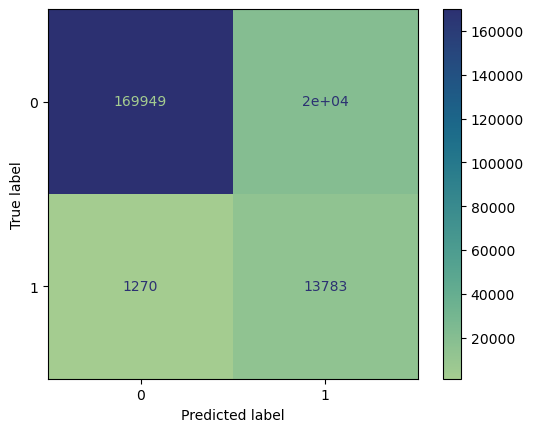

In [108]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='crest')
plt.show()

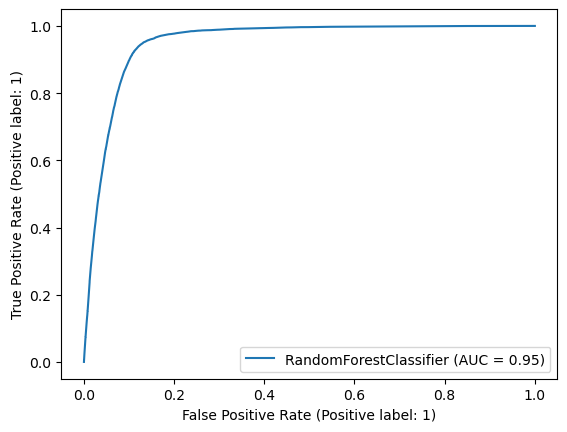

In [118]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()